In [30]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Model

import os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
matplotlib.style.use('ggplot')
%matplotlib inline

In [4]:
from skimage import io, color, filters

from PIL import Image
import requests
from io import BytesIO
from imageio import imread

In [12]:
df = pd.read_csv('../data/data_final.csv')
df

,ID,Name,Primary Type,Secondary Type,Image,Additional Images
0,#001,bulbasaur,Grass,Poison,https://img.pokemondb.net/sprites/bank/normal/...,['https://img.pokemondb.net/artwork/bulbasaur....
1,#002,ivysaur,Grass,Poison,https://img.pokemondb.net/sprites/bank/normal/...,['https://img.pokemondb.net/artwork/ivysaur.jp...
2,#003,venusaur,Grass,Poison,https://img.pokemondb.net/sprites/bank/normal/...,['https://img.pokemondb.net/artwork/venusaur.j...
3,#004,charmander,Fire,NaN,https://img.pokemondb.net/sprites/bank/normal/...,['https://img.pokemondb.net/artwork/charmander...
4,#005,charmeleon,Fire,NaN,https://img.pokemondb.net/sprites/bank/normal/...,['https://img.pokemondb.net/artwork/charmeleon...
...,...,...,...,...,...,...
893,#894,regieleki,Electric,NaN,https://img.pokemondb.net/sprites/sword-shield...,['https://img.pokemondb.net/artwork/regieleki....
894,#895,regidrago,Dragon,NaN,https://img.pokemondb.net/sprites/sword-shield...,['https://img.pokemondb.net/artwork/regidrago....
895,#896,glastrier,Ice,NaN,https://img.pokemondb.net/sprites/sword-shield...,['https://img.pokemondb.net/artwork/glastrier....
896,#897,spectrier,Ghost,NaN,https://img.pokemondb.net/sprites/sword-shield...,['https://img.pokemondb.net/artwork/spectrier....


In [13]:
def get_file_paths(path):
    '''
    Takes a folder path and returns a set of all file paths of .jpg in the folders
    Input: Folder path
    '''
    file_set = set()

    for direct, _, files in os.walk(path):
        for file_name in files:
            rel_dir = os.path.relpath(direct, path)
            rel_file = os.path.join(rel_dir, file_name)
            if '.png' not in rel_file:
                continue
            file_set.add(str(path)+rel_file)

    return file_set

def one_hotify(y, n_classes=None):
    '''Convert array of integers to one-hot format;
    The new dimension is added at the end.'''
    if n_classes is None:
        n_classes = max(y) + 1
    labels = np.arange(n_classes)
    y = y[..., None]
    return (y == labels).astype(int)

def load_images(path,size=(256,256)):
    
    file_paths = get_file_paths(path)
    
    images = []
    y = []
    for file in file_paths:
        img = keras.preprocessing.image.load_img(file, target_size=size)
        img_arr = keras.preprocessing.image.img_to_array(img.convert('RGBA'))[:,:,0:3]
        images.append(img_arr/255)
        y.append(file.split('/')[-1].split('_')[0])
    return images, y

In [14]:
pokedict = {}
for i in range(df.shape[0]):
    if str(df['Secondary Type'].loc[i]) != 'nan':
        pokedict[df['Name'].loc[i]] = [df['Primary Type'].loc[i], df['Secondary Type'].loc[i]]
    else:
        pokedict[df['Name'].loc[i]] = [df['Primary Type'].loc[i]]

In [15]:
X,y_names = load_images(('../images/'))
X = np.array(X)

In [16]:
y_type = []
for name in y_names:
    y_type.append(pokedict[name])
    
y = pd.Series(y_type)
y_dummies = pd.get_dummies(y.apply(pd.Series).stack()).sum(level=0)
y = np.array(y_dummies)
y

/Users/JosephLaurel/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  


array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=46, test_size=0.2,stratify = y)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=46, test_size=0.2,stratify = y_train)

In [19]:
class_dict = {}
sums = np.sum(y, axis = 0)
for i in range(y.shape[1]):
    class_dict[i] = sums[i]
for key,value in class_dict.items():
    class_dict[key] = 1462/value

In [40]:
def create_neural_net(model):
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(18,
                    activation='sigmoid',
                    kernel_regularizer=keras.regularizers.l2(0.01)))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(thresholds = 0.4),tf.keras.metrics.Recall(thresholds = 0.4)])

In [43]:
model2 = keras.models.Sequential()
create_neural_net(model2)

In [47]:
model2.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=16, class_weight = class_dict)

Train on 5350 samples, validate on 1338 samples
Epoch 1/50
5350/5350 [==============================] - 234s 44ms/sample - loss: 0.9648 - accuracy: 0.8769 - precision_7: 0.0920 - recall_7: 0.0802 - val_loss: 0.8048 - val_accuracy: 0.9078 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 2/50
5350/5350 [==============================] - 220s 41ms/sample - loss: 0.7277 - accuracy: 0.9077 - precision_7: 0.0491 - recall_7: 9.0070e-04 - val_loss: 0.6757 - val_accuracy: 0.9078 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 3/50
5350/5350 [==============================] - 217s 41ms/sample - loss: 0.6800 - accuracy: 0.9078 - precision_7: 0.2500 - recall_7: 1.1259e-04 - val_loss: 0.6404 - val_accuracy: 0.9078 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 4/50
5350/5350 [==============================] - 214s 40ms/sample - loss: 0.6613 - accuracy: 0.9078 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 0.6372 - val_accuracy: 0.9078 - val

5350/5350 [==============================] - 233s 43ms/sample - loss: 0.4039 - accuracy: 0.9248 - precision_7: 0.6536 - recall_7: 0.3836 - val_loss: 0.4578 - val_accuracy: 0.9221 - val_precision_7: 0.8588 - val_recall_7: 0.2604
Epoch 35/50
5350/5350 [==============================] - 231s 43ms/sample - loss: 0.3982 - accuracy: 0.9272 - precision_7: 0.6650 - recall_7: 0.4013 - val_loss: 0.4615 - val_accuracy: 0.9214 - val_precision_7: 0.8042 - val_recall_7: 0.2441
Epoch 36/50
5350/5350 [==============================] - 219s 41ms/sample - loss: 0.3964 - accuracy: 0.9267 - precision_7: 0.6572 - recall_7: 0.4005 - val_loss: 0.4613 - val_accuracy: 0.9216 - val_precision_7: 0.8256 - val_recall_7: 0.2581
Epoch 37/50
5350/5350 [==============================] - 251s 47ms/sample - loss: 0.3943 - accuracy: 0.9271 - precision_7: 0.6633 - recall_7: 0.4075 - val_loss: 0.4548 - val_accuracy: 0.9242 - val_precision_7: 0.8217 - val_recall_7: 0.2865
Epoch 38/50
5350/5350 [=============================

In [49]:
model2.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=16, class_weight = class_dict)

Train on 5350 samples, validate on 1338 samples
Epoch 1/50
5350/5350 [==============================] - 217s 41ms/sample - loss: 0.3654 - accuracy: 0.9313 - precision_7: 0.6778 - recall_7: 0.4644 - val_loss: 0.4385 - val_accuracy: 0.9286 - val_precision_7: 0.8098 - val_recall_7: 0.3356
Epoch 2/50
5350/5350 [==============================] - 215s 40ms/sample - loss: 0.3677 - accuracy: 0.9310 - precision_7: 0.6785 - recall_7: 0.4574 - val_loss: 0.4394 - val_accuracy: 0.9277 - val_precision_7: 0.8690 - val_recall_7: 0.3167
Epoch 3/50
5350/5350 [==============================] - 214s 40ms/sample - loss: 0.3638 - accuracy: 0.9315 - precision_7: 0.6842 - recall_7: 0.4706 - val_loss: 0.4384 - val_accuracy: 0.9272 - val_precision_7: 0.8812 - val_recall_7: 0.3140
Epoch 4/50
5350/5350 [==============================] - 215s 40ms/sample - loss: 0.3604 - accuracy: 0.9318 - precision_7: 0.6813 - recall_7: 0.4676 - val_loss: 0.4309 - val_accuracy: 0.9304 - val_precision_7: 0.8594 - val_recall_7: 0.3

Epoch 35/50
5350/5350 [==============================] - 214s 40ms/sample - loss: 0.3292 - accuracy: 0.9385 - precision_7: 0.7119 - recall_7: 0.5394 - val_loss: 0.4170 - val_accuracy: 0.9330 - val_precision_7: 0.8544 - val_recall_7: 0.3833
Epoch 36/50
5350/5350 [==============================] - 212s 40ms/sample - loss: 0.3294 - accuracy: 0.9378 - precision_7: 0.7110 - recall_7: 0.5379 - val_loss: 0.4139 - val_accuracy: 0.9345 - val_precision_7: 0.8750 - val_recall_7: 0.3941
Epoch 37/50
5350/5350 [==============================] - 214s 40ms/sample - loss: 0.3315 - accuracy: 0.9385 - precision_7: 0.7146 - recall_7: 0.5450 - val_loss: 0.4170 - val_accuracy: 0.9339 - val_precision_7: 0.8586 - val_recall_7: 0.3910
Epoch 38/50
5350/5350 [==============================] - 213s 40ms/sample - loss: 0.3260 - accuracy: 0.9393 - precision_7: 0.7186 - recall_7: 0.5500 - val_loss: 0.4190 - val_accuracy: 0.9325 - val_precision_7: 0.8432 - val_recall_7: 0.3851
Epoch 39/50
5350/5350 [=================

In [53]:
model2.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=16, class_weight = class_dict)

Train on 5350 samples, validate on 1338 samples
Epoch 1/50
5350/5350 [==============================] - 266s 50ms/sample - loss: 0.3181 - accuracy: 0.9408 - precision_7: 0.7197 - recall_7: 0.5698 - val_loss: 0.4106 - val_accuracy: 0.9364 - val_precision_7: 0.8619 - val_recall_7: 0.4275
Epoch 2/50
5350/5350 [==============================] - 251s 47ms/sample - loss: 0.3215 - accuracy: 0.9390 - precision_7: 0.7134 - recall_7: 0.5647 - val_loss: 0.4102 - val_accuracy: 0.9352 - val_precision_7: 0.8549 - val_recall_7: 0.4194
Epoch 3/50
5350/5350 [==============================] - 261s 49ms/sample - loss: 0.3173 - accuracy: 0.9399 - precision_7: 0.7194 - recall_7: 0.5671 - val_loss: 0.4150 - val_accuracy: 0.9345 - val_precision_7: 0.8957 - val_recall_7: 0.4023
Epoch 4/50
5350/5350 [==============================] - 278s 52ms/sample - loss: 0.3186 - accuracy: 0.9400 - precision_7: 0.7169 - recall_7: 0.5628 - val_loss: 0.4098 - val_accuracy: 0.9359 - val_precision_7: 0.8702 - val_recall_7: 0.4

Epoch 35/50
5350/5350 [==============================] - 308s 58ms/sample - loss: 0.3053 - accuracy: 0.9433 - precision_7: 0.7247 - recall_7: 0.5952 - val_loss: 0.4079 - val_accuracy: 0.9390 - val_precision_7: 0.8573 - val_recall_7: 0.4545
Epoch 36/50
5350/5350 [==============================] - 333s 62ms/sample - loss: 0.3014 - accuracy: 0.9429 - precision_7: 0.7288 - recall_7: 0.5978 - val_loss: 0.4097 - val_accuracy: 0.9366 - val_precision_7: 0.8430 - val_recall_7: 0.4257
Epoch 37/50
5350/5350 [==============================] - 351s 66ms/sample - loss: 0.2996 - accuracy: 0.9438 - precision_7: 0.7320 - recall_7: 0.6004 - val_loss: 0.4081 - val_accuracy: 0.9392 - val_precision_7: 0.8598 - val_recall_7: 0.4505
Epoch 38/50
5350/5350 [==============================] - 286s 53ms/sample - loss: 0.2999 - accuracy: 0.9436 - precision_7: 0.7325 - recall_7: 0.6036 - val_loss: 0.4081 - val_accuracy: 0.9376 - val_precision_7: 0.8639 - val_recall_7: 0.4459
Epoch 39/50
5350/5350 [=================

In [48]:
pre_trained_model = keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3),
    pooling=None)

x = keras.layers.Flatten()(pre_trained_model.output)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(.5)(x)
x = keras.layers.Dense(18,
                    activation='sigmoid',
                    kernel_regularizer=keras.regularizers.l2(0.01))(x)

model = Model(pre_trained_model.input,x)

In [37]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(thresholds = 0.4),tf.keras.metrics.Recall(thresholds = 0.4)])

In [38]:
model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=16, class_weight = class_dict)

Train on 5350 samples, validate on 1338 samples
Epoch 1/20
 128/5350 [..............................] - ETA: 1:04:12

KeyboardInterrupt: 

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
dense_4 (Dense)              (None, 6, 6, 128)         262272    
_________________________________________________________________
dense_5 (Dense)              (None, 6, 6, 18)          2322      
Total params: 22,067,378
Trainable params: 22,032,946
Non-trainable params: 34,432
_________________________________________________________________


Grass 65.0%
Rock 20.9%
Bug 14.7%
Poison 13.0%
Ground 2.96%


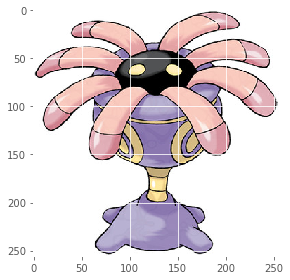

In [66]:
img = X_test[214]
classes = np.array(y_dummies.columns)
proba = model2.predict(img.reshape(1,256,256,3))
top_3 = np.argsort(proba[0])[:-6:-1]
for i in range(5):
    print("{}".format(classes[top_3[i]])+" {:.3}%".format(proba[0][top_3[i]]*100))
io.imshow(img);